Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import random #to generate random value b/w 0 and 1
from tqdm import tqdm #used just to find the remaining time, nothing more using this library

Installing Indic library and setting its path

In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git

fatal: destination path 'indic_nlp_library' already exists and is not an empty directory.
fatal: destination path 'indic_nlp_resources' already exists and is not an empty directory.


In [ ]:
!pip install Morfessor
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"
# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"

In [ ]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))

In [ ]:
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

In [ ]:
from indicnlp import loader
loader.load()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading train data from train.csv file

In [ ]:
import csv

data_hindi=[]
data_english=[]
with open('/content/drive/MyDrive/train.csv','r') as file:
  my_file=csv.reader(file,delimiter=',')
  for row in my_file:
    data_hindi.append(row[1:2])
    data_english.append(row[2:])

printing initial 10 hindi sentences

In [ ]:
print(data_hindi[:10])
print(data_english[:10])

[['hindi'], ['एल सालवाडोर मे, जिन दोनो पक्षों ने सिविल-युद्ध से वापसी ली, उन्होंने वही काम किये जो कैदियों की कश्मकश के निदान हैं।'], ['मैं उनके साथ कोई लेना देना नहीं है.'], ['-हटाओ रिक.'], ['क्योंकि यह एक खुशियों भरी फ़िल्म है.'], ['The thought reaching the eyes...'], ['मैंने तुमे School से हटवा दिया .'], ['यह Vika, एक फूल है.'], ['पर मेरे लिए उसका यहुदी विरोधी होना उसके कार्यों को और भी प्रशंसनीय बनाता है क्योंकि उसके पास भी पक्षपात करने के वही कारण थे जो बाकी फौजियों के पास थे पर उसकी सच जानने और उसे बनाए रखने की प्रेरणा सबसे ऊपर थी'], ['नहीं, नहीं, नहीं... ठीक है, हम उह हूँ... हम कार्ड का उपयोग करेंगे.']]
[['english'], ["In El Salvador, both sides that withdrew from their civil war took moves that had been proven to mirror a prisoner's dilemma strategy."], ['I have nothing to do with them.'], ['Fuck them, Rick.'], ["Because it's a happy film."], ['The thought reaching the eyes...'], ['I got you suspended.'], ["It's a flower, Vika."], ['But personally, for me, the fact that Picquar

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lem=WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Text Preprocessing

In [ ]:
import re
import string
def decontract(sentence):
  sentence=sentence[0].split()
  sentence=' '.join(sentence)
  sentence=re.sub(r"won't",'will not',sentence)
  sentence=re.sub(r"can't",'can not',sentence)
  sentence=re.sub(r"n\'t",' not',sentence)
  sentence=re.sub(r"\'re",' are',sentence)
  sentence=re.sub(r"\'d",' would',sentence)
  sentence=re.sub(r"\'ll",' will',sentence)
  sentence=re.sub(r"\'s",' is',sentence)
  sentence=re.sub(r"\'m",' am',sentence)
  sentence=re.sub(r"\'ve",' have',sentence)
  return sentence.split(' ')
  
def cleanEng(x):
  x=' '.join(x)
  x=str(x)
  x=x.lower()
  x=re.sub(r'[^a-z0-9]+',' ',x)
  x=re.sub(' +', ' ',x) #removing extra spaces 
  if len(x)>200:
    x=x[:200]
  if x and x[-1]==' ':
    x=x[:-1]
  x=x.split(' ')
  return x

def cleanHindi(x):
  x=' '.join(x)
  x=str(x)
  x=re.sub('[a-zA-Z]','',x)
  translator=str.maketrans('', '', string.punctuation)  #removing puncuations
  x=x.translate(translator)
  x=re.sub(' +', ' ',x)
  if len(x)>200:
    x=x[:200]
  if x and x[-1]==' ':
    x=x[:-1]
  x=x.split(' ')
  return x

Pre-process Test on a single example

In [ ]:
p=["In El Salvador, both sides that withdrew from their civil war took moves that had been proven to mirror a prisoner's dilemma strategy."]
p=list(decontract(p))
print(p)
p=cleanEng(p)
print(p)
for j in range(len(p)):
  p[j]=lem.lemmatize(p[j])
print(p)

['In', 'El', 'Salvador,', 'both', 'sides', 'that', 'withdrew', 'from', 'their', 'civil', 'war', 'took', 'moves', 'that', 'had', 'been', 'proven', 'to', 'mirror', 'a', 'prisoner', 'is', 'dilemma', 'strategy.']
['in', 'el', 'salvador', 'both', 'sides', 'that', 'withdrew', 'from', 'their', 'civil', 'war', 'took', 'moves', 'that', 'had', 'been', 'proven', 'to', 'mirror', 'a', 'prisoner', 'is', 'dilemma', 'strategy']
['in', 'el', 'salvador', 'both', 'side', 'that', 'withdrew', 'from', 'their', 'civil', 'war', 'took', 'move', 'that', 'had', 'been', 'proven', 'to', 'mirror', 'a', 'prisoner', 'is', 'dilemma', 'strategy']


Preprocess data

In [ ]:
for i in range(1,len(data_english)):
  data_english[i]=list(decontract(data_english[i]))
  data_english[i]=cleanEng(data_english[i])
  for j in range(len(data_english[i])):
    data_english[i][j]=lem.lemmatize(data_english[i][j])


In [ ]:
print(data_english[:200])

for i in data_english:
  if '[' in i:
    print(i)

[['english'], ['in', 'el', 'salvador', 'both', 'side', 'that', 'withdrew', 'from', 'their', 'civil', 'war', 'took', 'move', 'that', 'had', 'been', 'proven', 'to', 'mirror', 'a', 'prisoner', 'is', 'dilemma', 'strategy'], ['i', 'have', 'nothing', 'to', 'do', 'with', 'them'], ['fuck', 'them', 'rick'], ['because', 'it', 'is', 'a', 'happy', 'film'], ['the', 'thought', 'reaching', 'the', 'eye'], ['i', 'got', 'you', 'suspended'], ['it', 'is', 'a', 'flower', 'vika'], ['but', 'personally', 'for', 'me', 'the', 'fact', 'that', 'picquart', 'wa', 'anti', 'semitic', 'actually', 'make', 'his', 'action', 'more', 'admirable', 'because', 'he', 'had', 'the', 'same', 'prejudice', 'the', 'same', 'reason', 'to', 'be', 'biased', 'a', 'his', 'fellow', 'officer', 'but', 'his'], ['no', 'no', 'no', 'fine', 'we', 'will', 'uh', 'we', 'will', 'use', 'the', 'card'], ['', 'what', 'language', 'do', 'they', 'speak', 'there'], ['', 'gun', 'clicking'], ['it', 'is', 'thrilling'], ['so', 'in', 'smart', 'apart', 'from', 'th

In [ ]:
from indicnlp.normalize.indic_normalize import BaseNormalizer
remove_nuktas=False
normalizer=BaseNormalizer("hi",remove_nuktas=False)
for i in range(1,len(data_hindi)):
  data_hindi[i]=cleanHindi(data_hindi[i])
  x=' '.join(data_hindi[i])
  x=str(x)
  x=normalizer.normalize(x)
  x=x.split(' ')
  data_hindi[i]=x

In [ ]:
print(data_hindi[:1000])
for i in data_hindi:
  if '[' in i:
    print(i)

[['hindi'], ['एल', 'सालवाडोर', 'मे', 'जिन', 'दोनो', 'पक्षों', 'ने', 'सिविलयुद्ध', 'से', 'वापसी', 'ली', 'उन्होंने', 'वही', 'काम', 'किये', 'जो', 'कैदियों', 'की', 'कश्मकश', 'के', 'निदान', 'हैं।'], ['मैं', 'उनके', 'साथ', 'कोई', 'लेना', 'देना', 'नहीं', 'है'], ['हटाओ', 'रिक'], ['क्योंकि', 'यह', 'एक', 'खुशियों', 'भरी', 'फ़िल्म', 'है'], [''], ['मैंने', 'तुमे', 'से', 'हटवा', 'दिया'], ['यह', 'एक', 'फूल', 'है'], ['पर', 'मेरे', 'लिए', 'उसका', 'यहुदी', 'विरोधी', 'होना', 'उसके', 'कार्यों', 'को', 'और', 'भी', 'प्रशंसनीय', 'बनाता', 'है', 'क्योंकि', 'उसके', 'पास', 'भी', 'पक्षपात', 'करने', 'के', 'वही', 'कारण', 'थे', 'जो', 'बाकी', 'फौजियों', 'के', 'पास', 'थे', 'पर', 'उसकी', 'सच', 'जानने', 'और', 'उसे', 'बनाए', 'रखने', 'की', 'प्रेरणा', 'सबसे'], ['नहीं', 'नहीं', 'नहीं', 'ठीक', 'है', 'हम', 'उह', 'हूँ', 'हम', 'कार्ड', 'का', 'उपयोग', 'करेंगे'], ['', 'क्या', 'भाषा', 'क्या', 'वे', 'वहाँ', 'बात', 'की'], ['गन', 'क्लिक', 'करके'], ['ये', 'बिलकुल', 'रोमांचकारी', 'अनुभव', 'है।'], ['तो', 'स्मार्ट', 'में', 'हमारे', 'पास'

Analyzing some insigts in Train Dataset

In [ ]:
#A simple countvectorizer() from scratch

clean_data_english=data_english
clean_data_hindi=data_hindi
unique_hin=set()
unique_eng=set()
dict_eng={}
dict_hin={}

for i in range(len(clean_data_hindi)):
  for j in range(len(clean_data_hindi[i])):
    if clean_data_hindi[i][j] not in unique_hin:
      unique_hin.add(clean_data_hindi[i][j])
      dict_hin[clean_data_hindi[i][j]]=1
    else:
      dict_hin[clean_data_hindi[i][j]]+=1

for i in range(len(clean_data_english)):
  for j in range(len(clean_data_english[i])):
    if clean_data_english[i][j] not in unique_eng:
      unique_eng.add(clean_data_english[i][j])
      dict_eng[clean_data_english[i][j]]=1
    else:
      dict_eng[clean_data_english[i][j]]+=1

Sorting Dictionary by frequency in decreasing order

In [ ]:
dict_eng=sorted(dict_eng.items(),key=lambda p:p[1],reverse=True)  #sorted by frequency
dict_hin=sorted(dict_hin.items(),key=lambda p:p[1],reverse=True)  #sorted by frequency

In [ ]:
print('# of unique elements in hindi data:',len(dict_hin))
print('# of unique elements in english data:',len(dict_eng))

# of unique elements in hindi data: 46348
# of unique elements in english data: 26877


In [ ]:
print('printing top 10 frequent hindi elements:',dict_hin[:10])

printing top 10 frequent hindi elements: [('है', 39752), ('के', 29384), ('और', 23344), ('में', 22738), ('एक', 17178), ('हैं', 16584), ('से', 16442), ('की', 15606), ('मैं', 15499), ('नहीं', 14854)]


In [ ]:
print('printing top 10 frequent english elements:',dict_eng[:10])

printing top 10 frequent english elements: [('the', 39397), ('to', 27151), ('is', 26915), ('i', 25914), ('a', 25713), ('you', 25211), ('and', 24800), ('of', 19326), ('that', 17442), ('it', 16498)]


Word count of sentences in Train Data

In [ ]:
word_count_hin=[]
word_count_eng=[]

for i in range(len(clean_data_hindi)):
  word_count_hin.append(len(clean_data_hindi[i]))
  word_count_eng.append(len(clean_data_english[i]))

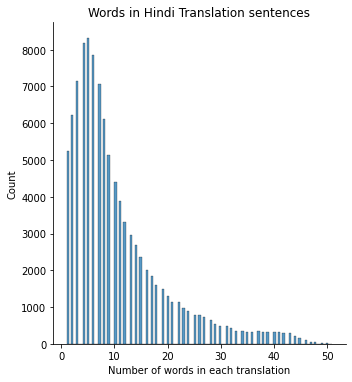

Most Hindi Translations have 5 words and # of such translations are 8327


In [ ]:
#Just for Visulalization Purpose seaborn and matplotlib libraries are imported. 
#Althrough, I also did the same using simple dictionary and list commands.
# Since, picture speaks more, so I use dthese libraries just to show the same.

import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(word_count_hin)
plt.title('Words in Hindi Translation sentences')
plt.xlabel('Number of words in each translation')
plt.show()

word_dict_hin={}
for i in word_count_hin:
  if i in word_dict_hin:
    word_dict_hin[i]+=1
  else:
    word_dict_hin[i]=1

word_dict_hin=sorted(word_dict_hin.items(),key=lambda p:p[1],reverse=True)
print('Most Hindi Translations have',word_dict_hin[0][0],'words and # of such translations are',word_dict_hin[0][1])

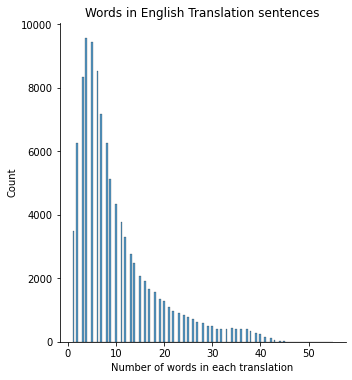

Most English Translations have 4 words and # of such translations are 9572


In [ ]:
#Just for Visulalization Purpose seaborn and matplotlib libraries are imported. 
#Althrough, I also did the same using simple dictionary and list commands.
# Since, picture speaks more, so I use dthese libraries just to show the same.

sns.displot(word_count_eng)
plt.title('Words in English Translation sentences')
plt.xlabel('Number of words in each translation')
plt.show()

word_dict_eng={}
for i in word_count_eng:
  if i in word_dict_eng:
    word_dict_eng[i]+=1
  else:
    word_dict_eng[i]=1

word_dict_eng=sorted(word_dict_eng.items(),key=lambda p:p[1],reverse=True)
print('Most English Translations have',word_dict_eng[0][0],'words and # of such translations are',word_dict_eng[0][1])

Add start and end token

In [ ]:
def addTokens(x,start=False):
  #Adding END token in sentences
  x.append('<END>')
  #Adding start token in Hindi sentences
  if start:
    x.insert(0,'<START>')
  return list(x)

In [ ]:
for i in range(len(clean_data_english)):
  clean_data_english[i]=addTokens(clean_data_english[i],start=True)
  clean_data_hindi[i]=addTokens(clean_data_hindi[i],start=False)

In [ ]:
print(clean_data_english[:10])
print(clean_data_hindi[:10])

[['<START>', 'english', '<END>'], ['<START>', 'in', 'el', 'salvador', 'both', 'side', 'that', 'withdrew', 'from', 'their', 'civil', 'war', 'took', 'move', 'that', 'had', 'been', 'proven', 'to', 'mirror', 'a', 'prisoner', 'is', 'dilemma', 'strategy', '<END>'], ['<START>', 'i', 'have', 'nothing', 'to', 'do', 'with', 'them', '<END>'], ['<START>', 'fuck', 'them', 'rick', '<END>'], ['<START>', 'because', 'it', 'is', 'a', 'happy', 'film', '<END>'], ['<START>', 'the', 'thought', 'reaching', 'the', 'eye', '<END>'], ['<START>', 'i', 'got', 'you', 'suspended', '<END>'], ['<START>', 'it', 'is', 'a', 'flower', 'vika', '<END>'], ['<START>', 'but', 'personally', 'for', 'me', 'the', 'fact', 'that', 'picquart', 'wa', 'anti', 'semitic', 'actually', 'make', 'his', 'action', 'more', 'admirable', 'because', 'he', 'had', 'the', 'same', 'prejudice', 'the', 'same', 'reason', 'to', 'be', 'biased', 'a', 'his', 'fellow', 'officer', 'but', 'his', '<END>'], ['<START>', 'no', 'no', 'no', 'fine', 'we', 'will', 'uh'

In [ ]:
validate_eng=clean_data_english[81858:]
validate_hin=clean_data_hindi[81858:]

Vocab Class

In [ ]:
#Vocab Class
class vocab:
  def __init__(self,data,token=True):
    self.data=data
    if token:
      self.word2idx={'<START>':1,'<END>':2,'<PAD>':0}
      self.idx2word={1:'<START>',2:'<END>',0:'<PAD>'}
      self.idx=2

    else:
      self.word2idx={'<PAD>':0,'<END>':1}
      self.idx2word={0:'<PAD>',1:'<END>'}
      self.idx=1

    self.x=[]
    self.create()
    self.vocab_size=self.idx+1

  def create(self):
    max_len=0
    #finding max length of sentence and creating word to index and index to word
    for sentence in  self.data:
      max_len=max(max_len,len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx+=1
          self.word2idx[word]=self.idx
          self.idx2word[self.idx]=word
    
    for sentence in self.data:
      sent=[]
      #Converting word to word to index(feature into vector form)
      for word in sentence:
        sent.append(self.word2idx[word])
      #Adding Padding in the last
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      #converting into Tensor
      self.x.append(torch.Tensor(sent))

In [ ]:
English_vocab=vocab(clean_data_english[1:],token=True)
Hindi_vocab=vocab(clean_data_hindi[1:],token=False)

In [ ]:
class parallelData(Dataset):
  def __init__(self):
    self.x=Hindi_vocab.x
    self.y=English_vocab.x
  def __getitem__(self,i):
    return self.x[i],self.y[i]
  def __len__(self):
    return len(self.x)

In [ ]:
dataset=parallelData() #dataset

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525

https://medium.com/intel-student-ambassadors/implementing-attention-models-in-pytorch-f947034b3e66

#Sequence to Sequence model with attention with Dropout 
with teaching score 0.6

In [ ]:
class encoder(nn.Module):

  def __init__(self,input_size,embedding_size,hidden_size,layers,bidirectional,p):
    super().__init__()
    #input_size=hindi_vocab size
    #embedding size=embedding dimension
    #layers=no. of layers
    #hidden size=hidden dimension
    #p=dropout parameter
    self.embed=nn.Embedding(num_embeddings=input_size,embedding_dim=embedding_size)
    self.lstm=nn.LSTM(input_size=embedding_size,hidden_size= hidden_size,num_layers=layers,batch_first=True,bidirectional=bidirectional)
    self.bidirectional=bidirectional
    self.dropout=nn.Dropout(p)
    self.fc_hidden=nn.Linear(hidden_size*2,hidden_size)
    self.fc_cell=nn.Linear(hidden_size*2,hidden_size)

  def forward(self,x):
    #x:(N,sequence_length)
    x=self.dropout(self.embed(x))
    #print(x.shape) #(N,sequence_length,embedding_size)
    #Calling LSTM
    output,(hidden_state,cell_state)=self.lstm(x)

    if self.bidirectional:
      #print(cell_shate.shape,hidden_state.shape)
      #Adding states of both the directions
      hidden=torch.cat((hidden_state[0:1],hidden_state[1:2]),dim=2)
      cell=torch.cat((cell_state[0:1],cell_state[1:2]),dim=2)
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    return output,hidden_state,cell_state

class decoder(nn.Module):

  def __init__(self,input_size,embedding_size,hidden_size,layers,p):

    super().__init__()
    #input_size=english_vocab size
    #embedding size=embedding dimension
    #layers=no. of layers
    #hidden size=hidden dimension
    #p=dropout parameter
    self.embed=nn.Embedding(num_embeddings=input_size,embedding_dim=embedding_size)
    self.dropout=nn.Dropout(p)
    self.lstm=nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc=nn.Linear(in_features=hidden_size, out_features=input_size)

  def forward(self,x,hidden_state, cell_state):
    
    x=x.reshape(-1,1)
    #print(x.shape) #(N,1)
    x=self.dropout(self.embed(x))
    #print(x.shape) #(N,1,embedding_size)
    output,(hidden_state, cell_state)=self.lstm(x,(hidden_state, cell_state))
    #sending output to fully connected layer
    output=self.fc(output) #(N,1,english_vocab)
    #convering to (N,vocab length) 
    output=output.squeeze(dim=1)

    return output,hidden_state,cell_state
    
class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):

    super().__init__()
    self.embed=nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
    self.lstm=nn.LSTM(input_size=hidden_size*2+embedding_size,hidden_size=hidden_size,num_layers=layers,batch_first=True)
    self.fc=nn.Linear(in_features=hidden_size,out_features=input_size)
    self.energy=nn.Linear(hidden_size*3,1) #2 from bidirectional, 1 for previous decoder
    self.softmax=nn.Softmax(dim=1)
  
  def forward(self,x,hidden_state,cell_state,encoder_states):

    batch_size=encoder_states.shape[0]
    seq_len=encoder_states.shape[1]
    hidden_size=encoder_states.shape[2]

    h_new=hidden_state.repeat(seq_len,1,1) #[sequence_len,N,2*hiddensize]
    h_new=h_new.permute(1,0,2) #[N,sequence_len,2*hiddensize]

    energy=self.energy(torch.cat((h_new, encoder_states), dim=2))
    #Attention weights to the input
    att_weights=self.softmax(energy)
    att_weights=att_weights.permute(0,2,1) #[N,1,sequence_len]
    #Multiplying attention weight with encoder state
    context=torch.bmm(att_weights, encoder_states) #[N,1,hiddensize*2]

    x=x.reshape(-1,1) #[N,1]
    x=self.embed(x) #[N,1,embeddingsize]
    #print(x.shape)

    input_new=torch.cat((context,x), dim=2) #[N,1,hidden*2+embedding]
    #print(input_new.shape)

    output,(hidden_state, cell_state)=self.lstm(input_new,(hidden_state, cell_state))
    output=self.fc(output) #[N,1,english_vocab]
    output=output.squeeze(dim=1) #[N,english_vocab]

    del input_new
    del context
    del h_new

    return output,hidden_state,cell_state

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):

    super().__init__()
    self.encoder=encoder
    self.decoder=att_decoder

  def forward(self, input, target, teaching_force=0.6):
    #Teaching forcing is used to get actual word. Sometimes , we are using actual word, sometimes predicted word. A very high techer forcing\
    # can lead to overfitting. Value 0 can lead to underfit if model makes incorrect prediction and it can go on continuous in the chain.
    batch_size =input.shape[0]
    seq_len=target.shape[1]
    eng_vocab_size=English_vocab.vocab_size

    #predicting 1 word at a time.
    output=torch.zeros((seq_len, batch_size, eng_vocab_size)).to(device)
    #finding encoder state, hidden state and cell state of the input from encoder.
    encoder_states,hidden, cell=self.encoder(input)
    target=target.permute(1,0) #[sequence_len,N]
    x=target[0] #picking Start token

    for i in range(1,seq_len):
      out,hidden,cell=self.decoder(x, hidden, cell, encoder_states)
      #out size=(batch size, target_vocab_size)
      output[i]=out
      decoder_guess=out.argmax(1) #argmax of first dimension
      if random.random()<teaching_force:
        x=target[i]
      else:
        x=decoder_guess

    return output

In [ ]:
#Hyperparameters
#using cuda if available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=20
learning_rate=0.001
batch_size=128
embedding_size=512
hidden_size=512
layers=1
bidirectional=True

In [ ]:
loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)  #shuffling the data and converting data into batches

In [ ]:
#calling encoder
ENC=encoder(Hindi_vocab.vocab_size,embedding_size,hidden_size,layers,bidirectional,0.1).to(device) 
#calling Attention Decoder
DE=AttnDecoder(English_vocab.vocab_size,embedding_size,hidden_size,layers).to(device) 
#Attention Model
model=Attnseq2seq(ENC,DE).to(device) 
#Adam Optimizer
optimizer=optim.Adam(model.parameters(),lr=learning_rate) 
#Cross Entropy Loss, ince for english pad index is 0, so, ignore pad indices in comparison
criterion=nn.CrossEntropyLoss(ignore_index=0) 

In [ ]:
train_loss = []
#tqdm is used just to find remaining time
for epoch in tqdm(range(num_epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    #Iterate over training data in baches of 120
    x=x.long().to(device)#input
    y=y.long().to(device)#target
    #forward pass
    output=model(x,y)
    #Discard start token, keep dimension as that of target vocab
    output=output[1:].reshape(-1,output.shape[2])
    y=y.permute(1,0)
    #Discard start token
    y=y[1:].reshape(-1)
    optimizer.zero_grad()
    #CE Loss
    loss=criterion(output,y)
    #Backward pass
    loss.backward()
    #clipping gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    optimizer.step()
  #printing loss and number of epochs completed
  print(f'[{epoch+1}/{num_epochs}] loss={loss.item()}')
  train_loss.append(loss.item())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

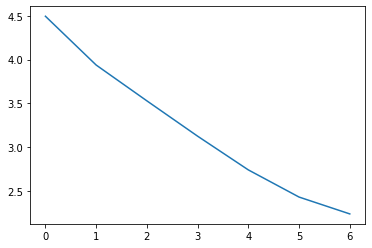

In [ ]:
#plotting loss
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

Saving model state

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/model_20111002.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model_20111002.pt'))

<All keys matched successfully>

Validation Phase:

In [ ]:
def prediction(x):
  x=x.long().reshape(1,-1).to(device)
  ans=translate(x)
  res=[]
  for id in ans:
    #getting english word for the corresponding id of hindi word
    res.append(English_vocab.idx2word[id])
  return res

In [ ]:
def translate(input):
  with torch.no_grad():
    guess=[]
    encoder_states,hidden,cell=model.encoder(input)
    x=torch.ones((1)).long().to(device)
    c=0
    while True:
      out,hidden,cell=model.decoder(x,hidden,cell,encoder_states)
      x=out.argmax(1)
      c+=1
      guess.append(int(x[0].detach().cpu()))
      #End of the sentence
      if x == 2 or c>100:
        break
  return guess

In [ ]:
for i in range(0,100):
  res=prediction(dataset[i][0])
  print(res)

['in', '2012', 'kaggle', 'challenged', 'the', 'community', 'that', 'withdrew', 'the', 'program', 'called', 'the', 'biotechnology', 'of', 'the', 'community', 'who', 'have', 'been', 'trained', 'to', 'work', '<END>']
['i', 'do', 'not', 'have', 'to', 'do', 'with', 'them', '<END>']
['get', 'to', 'the', 'cab', '<END>']
['because', 'it', 'is', 'a', 'happy', 'life', '<END>']
['', '<END>']
['i', 'have', 'made', 'you', '<END>']
['it', 'is', 'a', 'flower', '<END>']
['but', 'for', 'me', 'the', 'same', 'thing', 'that', 'had', 'a', 'huge', 'difference', 'between', 'her', 'and', 'the', 'same', 'thing', 'but', 'he', 'could', 'not', 'be', 'the', 'greatest', 'source', 'of', 'his', 'greatest', 'reason', 'because', 'it', 'wa', 'the', 'most', 'important', 'thing', '<END>']
['no', 'no', 'no', 'no', 'we', 'will', 'do', 'we', 'will', 'call', 'this', '<END>']
['', 'what', 'language', 'they', 'speak', 'up', 'there', '<END>']
['', 'gun', 'clicking', '<END>']
['that', 'is', 'not', 'experience', '<END>']
['so', 'i

In [ ]:
def get(sent):
  token=[]
  #convering word to index for test sentence
  for word in sent:
    if Hindi_vocab.word2idx.get(word) is None:
      token.append(Hindi_vocab.word2idx['है']) #OOV word(Out-of-vocabulary word) #Replacement concept from Most frequent word in vocab
    else:
      token.append(Hindi_vocab.word2idx[word])
  #converting into sentor
  sent=torch.tensor(token).float()
  #calling prediction function
  res=prediction(sent)
  return res

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5MB 19.2MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


#Test Phase:

In [ ]:
test_hindi=[]
with open('/content/drive/MyDrive/testhindistatements.csv','r') as file:
  my_file=csv.reader(file,delimiter=',')
  for row in my_file:
    test_hindi.append(row[2:])

In [ ]:
print(test_hindi[:10])

[['hindi'], ['(तालियां) अब, इसने मेरे मन को उड़ा दिया।'], ['पर आप बहुत धाँसू लग रहे हैं।'], ['शास्त्र समझ्ने के रा स्ते बनाती है|'], ['कृपया मेरी बात सुनो।'], ['नहीं, क्लार्क, तुम नहीं कर सकते।'], ['उसमे बेहतरीन सौर सेल लगे हुए हैं .'], ['वह एक जानवर है जो पैसे के लिए किसी भी स्तर तक गिर जाएगा'], ['किसके लिए?" तो एक छोटी सी लड़की जिसे आपने अभी देखा, उसने हाथ उठाया, और उसने मुझे टूटी हुई तमिल और अंग्रेज़ी में कहा, उसने कहा, "ठीक है, इस तथ्य के अलावा कि डीएनए अणु के अनुचित प्रतिकृति रोग का कारण बनते है, हमें कुछ समझ में नहीं आया है. "'], ['वे देख रहे हैं।']]


In [ ]:
test_hindi=test_hindi[1:]
print(len(test_hindi))

In [ ]:
for i in range(len(test_hindi)):
  test_hindi[i]=cleanHindi(test_hindi[i])
  x=' '.join(test_hindi[i])
  x=str(x)
  x=normalizer.normalize(x)
  x=x.split(' ')
  test_hindi[i]=x

In [ ]:
print(test_hindi[:100])

In [ ]:
#Count Vectorizer from scratch for test data
unique_test=set()
dict_test=dict()
word_count_test=[]
for i in range(len(test_hindi)):
  word_count_test.append(len(test_hindi[i]))
  for j in range(len(test_hindi[i])):
    if test_hindi[i][j] in dict_test:
      dict_test[test_hindi[i][j]]+=1
    else:
      dict_test[test_hindi[i][j]]=1
    if test_hindi[i][j] not in unique_hin:
       unique_test.add(test_hindi[i][j])

In [ ]:
print('# of unique words that are not in train data:',len(unique_test))
print(unique_test)

# of unique words that are not in train data: 5723
{'बिछड़ा', 'औरउसकेदेवताओंकेमंदिरों', 'तिपहिया', 'सुनामीसफाया', 'बूझके', 'खस्ताहाल।', 'सबधी', 'एंड्रयूज़', 'ठीकाने', 'होगापेले', '69000', 'कसाईखाना', 'टॉल्स्टॉय', 'पानीछिड़काव', 'संपोषित', 'प्रतिचित्रित', 'परहित', 'ख़ज़ाँची', 'गोदने', 'पारदर्शिता।', 'उन्होनों', 'इंटेलिजेंस', 'स्क्रैपर', 'पीडादायक', 'ट्रेक्टर', 'रुकावटें', 'साइलेंट', 'रोकीं', 'हवामें', 'कम्यूटेशनल', 'अभिलेखीय', 'थमाओ', 'तीरकमान', 'तेल।', 'मुक़ाबले', 'मुरझाकर', 'हमवेयोजनाहैसावधानियों', 'निगमित', '700000', 'कहाने', 'हड्डियांमे', 'गिफ़्ट', 'डब्ल्यु', 'को़ड', 'घिरीं', 'किपताथा', 'संवेद्ना', 'कठ', 'जसेरी', 'बीमिरियों', 'पैकेज।', 'लेनं', 'मेरेलिए', 'आर्किया', 'दिवालोक', 'उखाड़के', 'फ़्लोर', 'टिकेट।', 'निजआत्म', 'सोखने', 'रहामैं', 'तोड़ो।', 'तम्हें', 'रॉयटर्स', 'बेनाम', 'बकरियोंकी', 'म्च्चर्य्स्तल', 'क्याबकवासमैंकररहाहूँवालेहैं', 'लिएफिरभी', 'खालीद', 'रोलरों', 'रोगमुक्त', 'नीरसअर्थहीनऔर', 'टोस्टर', 'क्वालालंगा', 'ख़ाते', 'एएचआप', 'खासियतें', 'तमिलों', 'वेबपेज', 'बस्स', 'सरोगेसी', '

In [ ]:
dict_test=sorted(dict_test.items(),key=lambda p:p[1],reverse=True)

In [ ]:
print('printing top 10 frequent hindi elements in test data:',dict_test[:10])

printing top 10 frequent hindi elements in test data: [('है', 9418), ('के', 6842), ('और', 5629), ('में', 5387), ('एक', 3942), ('हैं', 3928), ('से', 3840), ('मैं', 3634), ('नहीं', 3624), ('की', 3560)]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


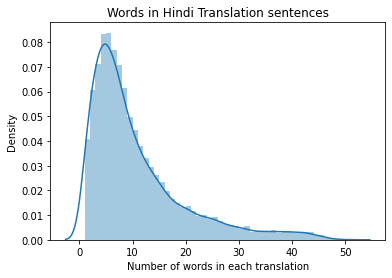

[(5, 2021), (4, 2005), (6, 1854), (3, 1716), (7, 1706), (8, 1480), (2, 1458), (9, 1194), (10, 1076), (1, 980), (11, 911), (12, 794), (13, 713), (14, 631), (15, 564), (16, 473), (17, 402), (18, 357), (20, 329), (19, 318), (21, 279), (23, 241), (22, 230), (25, 224), (24, 205), (26, 183), (27, 156), (28, 140), (29, 138), (31, 131), (30, 108), (36, 93), (38, 85), (33, 84), (39, 83), (34, 82), (32, 81), (35, 77), (41, 75), (42, 74), (43, 73), (40, 70), (37, 67), (45, 48), (44, 43), (46, 22), (47, 14), (48, 7), (51, 3), (49, 3), (50, 1)]
Most Hindi Translations have 5 words and # of such translations are 2021


In [ ]:
#Just for Visulalization Purpose seaborn and matplotlib libraries are imported. 
#Althrough, I also did the same using simple dictionary and list commands.
# Since, picture speaks more, so I use dthese libraries just to show the same.
 
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(word_count_test)
plt.title('Words in Hindi Translation sentences')
plt.xlabel('Number of words in each translation')
plt.show()

word_dict_test={}
for i in word_count_test:
  if i in word_dict_test:
    word_dict_test[i]+=1
  else:
    word_dict_test[i]=1

word_dict_test=sorted(word_dict_test.items(),key=lambda p:p[1],reverse=True)
print(word_dict_test)
print('Most Hindi Translations have',word_dict_test[0][0],'words and # of such translations are',word_dict_test[0][1])

In [ ]:
test_dataset=vocab(test_hindi,token=False)

In [ ]:
res=get(test_hindi[1])[:-1]
print(res)
print(test_hindi[1][:-1])

['but', 'you', 'look', 'very', 'much']
['पर', 'आप', 'बहुत', 'धाँसू', 'लग', 'रहे']


In [ ]:
pred=[]
actu=[]
for i in tqdm(range(len(test_hindi))):
  #getting translation for each statement
  k=get(test_hindi[i])[:-1]
  q=test_hindi[i][:-1]
  actu.append(q)
  pred.append(k)

100%|██████████| 24102/24102 [04:24<00:00, 91.07it/s] 


printing Translations

In [ ]:
for i in range(len(pred)):
  print(pred[i],actu[i])

Streaming output truncated to the last 5000 lines.
['our', 'belief', 'only', 'one', 'men', 'believe', 'we', 'believe', 'that', 'men'] ['हमारा', 'केवल', 'युवा', 'पुरुषों', 'का', 'मानना', '', '', 'है', 'कि', 'एक', 'मिथक']
['', 'you', 'will', 'have', 'nothing'] ['', 'आप', 'कुछ', 'भी', 'प्राप्त']
['tony', 'please', 'do', 'not', 'know', 'any', 'idea', 'what', 'i', 'do'] ['सावधानी', 'बरतने', 'में', 'कोई', 'नुक्सान', 'नहीं']
['so', 'in', 'the', 'real', 'estate', 'of', 'the', 'book', 'that', 'had', 'been', 'called', 'the', 'chinese', 'in', 'the', 'street'] ['तो', 'असली', 'वेब', 'के', 'विधान', 'में', 'उन्होंने', 'एक', 'सर्वेक्षण', 'तैयार', 'किया', 'जिसमें', 'उनके', 'पास', 'बहुत', 'विचारपूर्ण', 'सुलझे', 'हुए', 'नाम', 'का', 'झुंड']
['i', 'am', 'gonna', 'help', 'you', 'are', 'gonna', 'help', 'me'] ['मैं', 'ठीक', 'है', 'तुम', 'मदद', 'करने', 'वाला']
['i', 'believe', 'that', 'you', 'really', 'think', 'about', 'these', 'two', 'year', 'ago'] ['मुझे', 'सच', 'बताओ', 'कम', 'से', 'कम', 'इन', 'आखिरी', 'पलों

Writing predicted tranlations to text file

In [ ]:
f = open("/content/drive/MyDrive/Finalphase_answer.txt","w")
for i in range(len(pred)):
  print(i,pred[i])
  s=' '.join(pred[i])
  s+='\n'
  f.write(s)

Streaming output truncated to the last 5000 lines.
19102 ['our', 'belief', 'only', 'one', 'men', 'believe', 'we', 'believe', 'that', 'men']
19103 ['', 'you', 'will', 'have', 'nothing']
19104 ['tony', 'please', 'do', 'not', 'know', 'any', 'idea', 'what', 'i', 'do']
19105 ['so', 'in', 'the', 'real', 'estate', 'of', 'the', 'book', 'that', 'had', 'been', 'called', 'the', 'chinese', 'in', 'the', 'street']
19106 ['i', 'am', 'gonna', 'help', 'you', 'are', 'gonna', 'help', 'me']
19107 ['i', 'believe', 'that', 'you', 'really', 'think', 'about', 'these', 'two', 'year', 'ago']
19108 ['', 'and', 'young', 'man', 'never', 'in', 'the', 'age', 'of', 'the', 'year']
19109 ['and', 'the', 'video', 'of', 'the', 'nigerian', 'publisher', 'were', 'trying', 'to', 'try', 'to', 'write', 'a', 'game', 'of', 'the', 'game', 'of', 'the', 'game', 'of', 'the', 'world', 'that', 'wa', 'trying', 'to', 'do', 'with', 'the', 'right']
19110 ['oh', 'hell']
19111 ['i', 'am', 'only', 'one', 'i', 'am', 'only', 'one', 'of', 'the',